# PART 1 Extract data from 2 sources: lazada and shopee
This is the first step to scraping data from 2 sources, lazada.co.th and shoppee.co.th, which is a shopping online website that provided a lot of information about products e.g., product name, price, store name, item model, rate, reviews, spec and etc. \
This part run process as synchronous process, scraping from lazada first and then shopee and then saving file from to sources to tmp_data folder that collect raw data and prepared for transformation in the next process. \
Below are the functional processes in scraping both source from start to A , B, C, and D respectfully.

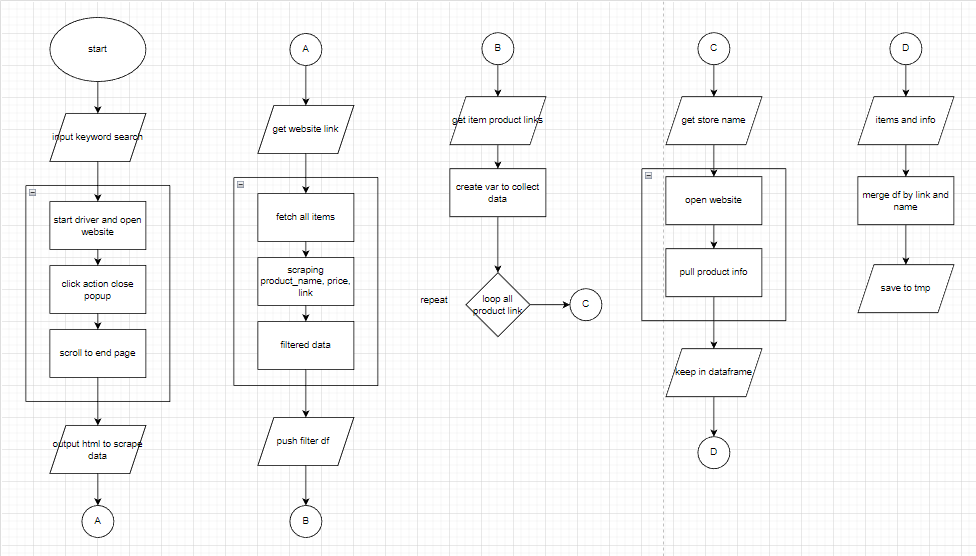

In [11]:
# global variable search_term that we can changed to get data.
search_term = 'keychron k4'

In [23]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException, StaleElementReferenceException
from bs4 import BeautifulSoup
from importlib import reload
import csv
from time import sleep
import time
from urllib.parse import urljoin
import pandas as pd
import requests
import json
import random
from dependencies import scraping, driver

TEMP_DATA = '../tmp_data/'
LAZADA_PLATFORM = 'lazada'
SHOPEE_PLATFORM = 'shopee'

def get_driver():
    # setting webdriver selenium -- aviod bot detected
    option = webdriver.ChromeOptions()
    # Removes navigator.webdriver flagIngest
    option.add_experimental_option("excludeSwitches", ["enable-automation"])
    option.add_experimental_option('useAutomationExtension', False)
    option.add_experimental_option("prefs", {
        "profile.default_content_setting_values.notifications": 2
    })
    option.add_argument('--headless')
    option.add_argument('--no-sandbox')
    option.add_argument("--incognito")
    option.add_argument('disable-notifications')
    option.add_argument('--disable-infobars')
    option.add_argument('start-maximized')
    # To disable the message, "Chrome is being controlled by automated test software"
    option.add_argument("disable-infobars")
    option.add_argument('--disable-blink-features=AutomationControlled')
    option.add_argument("window-size=1280,800")
    
    return webdriver.Chrome(executable_path='./chromedriver.exe', options=option)



## 1.1 Extract From Lazada platform
https://www.lazada.co.th/

### Fetch all item that metched with search term
get product name, price, sold items, and alink (use to merge with item info later).

In [15]:
driver = get_driver()
lazada_items = scraping.fetch_lazada_items(search_term, driver)
lazada_items.head()

<ipython-input-14-5ca10fd545e7>:43: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  return webdriver.Chrome(executable_path='./chromedriver.exe', options=option)


,alink,product_name,price,sold
0,https://www.lazada.co.th/products/keychron-k4-...,Keychron K4 Wireless Keyboard Thai (คีย์บอร์ดไ...,"฿4,390.00",792 ชิ้น
1,https://www.lazada.co.th/products/keychron-k4-...,Keychron K4 hotswap (Key ENG) Mechanical Keybo...,"฿3,799.00",None
2,https://www.lazada.co.th/products/keychron-k4-...,Keychron K4 G V2บลูทูธไร้สายคีย์บอร์ดแบบกลไก W...,"฿3,599.00",None
3,https://www.lazada.co.th/products/in-stock-key...,[ประกันไทย] [in stock] Keychron K4 V2 คีย์บอร์...,"฿3,150.00",67 ชิ้น
4,https://www.lazada.co.th/products/keychron-k4-...,Keychron K4 V2 เอฟเฟกต์แสงหลายโหมดแบบคู่ คีย์...,"฿3,150.00",139 ชิ้น


### Clean data and filter data
check duplicate data and drop them all. Then filter data by checking macthing keyword search_term and product name

In [17]:
print('item duplicated',lazada_items.duplicated(subset=['alink','product_name']).sum())
lazada_items.drop_duplicates(subset=['alink','product_name'], inplace=True)

item duplicated 40


In [19]:
def item_matched_kw(product_name:str):
  """check product name is matched with search term keyword, drop if not match"""
  words =  search_term.split(' ')
  matched = True
  for key in words:
    if key.lower() not in product_name.lower():
      matched = False
  # print(matched)
  return matched
    
lazada_items['matched'] = lazada_items['product_name'].apply(item_matched_kw)
lazada_items_filter = lazada_items[lazada_items['matched']==True]
lazada_items_filter.tail()

,alink,product_name,price,sold,matched
115,https://www.lazada.co.th/products/keychron-k4-...,Keychron K4 J V2บลูทูธไร้สายคีย์บอร์ด RGB Back...,"฿8,461.00",None,True
116,https://www.lazada.co.th/products/keychron-v2-...,Keychron V2 K4 G คีย์บอร์ดแบบกลไกไร้สายบลูทูธไ...,"฿5,128.00",None,True
117,https://www.lazada.co.th/products/keychron-v2-...,Keychron V2 K4 G คีย์บอร์ดแบบกลไกไร้สายบลูทูธไ...,"฿5,345.00",None,True
160,https://www.lazada.co.th/products/keychron-key...,【แป้นพิมพ์】 Keychron keyboard wooden hand rest...,฿909.00,None,True
170,https://www.lazada.co.th/products/keychron-k4v...,【แป้นพิมพ์】 ツKeychron-K4V2 คีย์บอร์ดบลูทูธไร้ส...,"฿4,184.00",None,True


In [44]:
# import dependencies
# reload(dependencies.scraping)
# from  dependencies import scraping

### Scraping item infomation of product
loop each alink that we filtered, then scrape each product link to get store_name, brand_name, specification, rating	

In [33]:
item_info_filter = scraping.get_item_info_lazada(lazada_items_filter['alink'], get_driver())

<ipython-input-23-c90e4b88877b>:46: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  return webdriver.Chrome(executable_path='./chromedriver.exe', options=option)


In [34]:
item_info_filter

,alink,store_name,brand_name,specification,rating,platform
0,https://www.lazada.co.th/products/keychron-k4-...,Keychron,Keychron,Dark Gray,None,lazada
1,https://www.lazada.co.th/products/keychron-k4-...,BIGPENGUIN,No Brand,Aluminium -Dark Grey,None,lazada
2,https://www.lazada.co.th/products/keychron-k4-...,Keychron dealer,Keychron,Blue,None,lazada
3,https://www.lazada.co.th/products/in-stock-key...,gMPrbXQX,No Brand,Red switch-K4 RGB,None,lazada
4,https://www.lazada.co.th/products/keychron-k4-...,cc Key Shop,No Brand,Brown switch-K4 LED,None,lazada
...,...,...,...,...,...,...
72,https://www.lazada.co.th/products/keychron-k4-...,xcr288,No Brand,Blue Switches,None,lazada
73,https://www.lazada.co.th/products/keychron-v2-...,sf8sfjergdr,No Brand,Blue Switches,None,lazada
74,https://www.lazada.co.th/products/keychron-v2-...,ivnqbo,No Brand,Brown Switches,None,lazada
75,https://www.lazada.co.th/products/keychron-key...,qi sheng trade,No Brand,K3,None,lazada


### Merging product name and thier info
store_name, brand_name, specification, rating by alink

In [35]:
merge_lazada = lazada_items_filter.merge(item_info_filter, left_on='alink', right_on='alink')
merge_lazada.tail()

,alink,product_name,price,sold,matched,store_name,brand_name,specification,rating,platform
72,https://www.lazada.co.th/products/keychron-k4-...,Keychron K4 J V2บลูทูธไร้สายคีย์บอร์ด RGB Back...,"฿8,461.00",None,True,xcr288,No Brand,Blue Switches,None,lazada
73,https://www.lazada.co.th/products/keychron-v2-...,Keychron V2 K4 G คีย์บอร์ดแบบกลไกไร้สายบลูทูธไ...,"฿5,128.00",None,True,sf8sfjergdr,No Brand,Blue Switches,None,lazada
74,https://www.lazada.co.th/products/keychron-v2-...,Keychron V2 K4 G คีย์บอร์ดแบบกลไกไร้สายบลูทูธไ...,"฿5,345.00",None,True,ivnqbo,No Brand,Brown Switches,None,lazada
75,https://www.lazada.co.th/products/keychron-key...,【แป้นพิมพ์】 Keychron keyboard wooden hand rest...,฿909.00,None,True,qi sheng trade,No Brand,K3,None,lazada
76,https://www.lazada.co.th/products/keychron-k4v...,【แป้นพิมพ์】 ツKeychron-K4V2 คีย์บอร์ดบลูทูธไร้ส...,"฿4,184.00",None,True,xuan rui trade,No Brand,A1-white light ver Official standard,None,lazada


### Save data to temporary storage

In [39]:
file_name = search_term.replace(' ', '_')
merge_lazada.drop_duplicates(subset=['alink','product_name'], inplace=True)
merge_lazada.to_csv(f'{TEMP_DATA}{file_name}_{LAZADA_PLATFORM}.csv', index=False, encoding='utf-8-sig')

____
## 1.2 Extract From Shopee platform
https://shopee.co.th

In [46]:
import dependencies
reload(dependencies.scraping)
from  dependencies import scraping

### Fetch all item that metched with search term
get product name, price, and alink (use to merge with item info later).

In [47]:
shopee_items = scraping.fetch_shopee_items(search_term, get_driver())
shopee_items.head()

<ipython-input-23-c90e4b88877b>:46: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  return webdriver.Chrome(executable_path='./chromedriver.exe', options=option)


https://shopee.co.th/search?keyword=keychron+k4&page={}


,product_name,price,alink
0,Keychron K4 V.2 Hotswappable (Key ENG) ⌨ ขนาด ...,4190,https://shopee.co.th/Keychron-K4-V.2-Hotswappa...
1,Keychron K4V2 คีย์ครอน K4 คีย์บอร์ดไร้สาย Wire...,4190,https://shopee.co.th/Keychron-K4V2-คีย์ครอน-K4...
2,Keychron ที่พักข้อมือไม้วอลนัท สําหรับ K2 K4 K...,569,https://shopee.co.th/Keychron-ที่พักข้อมือไม้ว...
3,[ประกันไทย] [in stock] Keychron K2 V2 RGB คีย์...,3240,https://shopee.co.th/-ประกันไทย-in-stock-Keych...
4,Keychron V5 QMK/VIA Change Key Customized Mech...,2550,https://shopee.co.th/Keychron-V5-QMK-VIA-Chang...


### Clean data and filter data

In [51]:
shopee_items.duplicated(subset=['alink']).sum()
shopee_items['matched'] = shopee_items['product_name'].apply(item_matched_kw)
shopee_items_filter = shopee_items[shopee_items['matched']==True]
shopee_items_filter

,product_name,price,alink,matched
0,Keychron K4 V.2 Hotswappable (Key ENG) ⌨ ขนาด ...,4190,https://shopee.co.th/Keychron-K4-V.2-Hotswappa...,True
1,Keychron K4V2 คีย์ครอน K4 คีย์บอร์ดไร้สาย Wire...,4190,https://shopee.co.th/Keychron-K4V2-คีย์ครอน-K4...,True
2,Keychron ที่พักข้อมือไม้วอลนัท สําหรับ K2 K4 K...,569,https://shopee.co.th/Keychron-ที่พักข้อมือไม้ว...,True
5,Keychron K4 V.2 Hotswappable (Key ENG) ⌨ ขนาด ...,1729,https://shopee.co.th/Keychron-K4-V.2-Hotswappa...,True
6,[ประกันไทย] [in stock] Keychron K4 V2 คีย์บอร์...,1364,https://shopee.co.th/-ประกันไทย-in-stock-Keych...,True
...,...,...,...,...
295,[ประกันไทย] [in stock] Keychron K4 V2 คีย์บอร์...,1736,https://shopee.co.th/-ประกันไทย-in-stock-Keych...,True
296,Keychron K4 V2 คีย์บอร์ดเกมมิ่งไร้สายบลูทูธ มี...,4180,https://shopee.co.th/Keychron-K4-V2-คีย์บอร์ดเ...,True
297,[ประกันไทย] [in stock] Keychron K4 V2 คีย์บอร์...,1744,https://shopee.co.th/-ประกันไทย-in-stock-Keych...,True
298,★[Carrying Case] RK Keychron กระเป๋าเก็บแป้นพิ...,1599,https://shopee.co.th/★-Carrying-Case-RK-Keychr...,True


### Scraping item infomation of product

In [52]:
shopee_info_filter = scraping.get_item_info_shopee(shopee_items_filter['alink'][:100], get_driver())

<ipython-input-23-c90e4b88877b>:46: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  return webdriver.Chrome(executable_path='./chromedriver.exe', options=option)


In [54]:
shopee_info_filter.tail(10)

,alink,store_name,brand_name,price_range,rating,sold,platform
90,https://shopee.co.th/ประกันไทย-in-stock-Keychr...,None,None,None,None,None,shopee
91,https://shopee.co.th/Keychron-K4-V.2-Wireless-...,None,None,None,None,None,shopee
92,https://shopee.co.th/✥❧♈เคสแป้นพิมพ์-ฝาครอบป้อ...,None,None,None,None,None,shopee
93,https://shopee.co.th/Keychron-K4-V2-คีย์บอร์ด-...,None,None,None,None,None,shopee
94,https://shopee.co.th/Keychron-K4-V2-คีย์บอร์ด-...,quzx01ez76,None,"฿1,566 - ฿1,838",None,0,shopee
95,https://shopee.co.th/☼✶Keychron-K4V2-คีย์ครอน-...,None,None,None,None,None,shopee
96,https://shopee.co.th/❣✘-ประกันไทย-in-stock-Key...,None,None,None,None,None,shopee
97,https://shopee.co.th/❣Keychron-K4-V2-คีย์บอร์ด...,None,None,None,None,None,shopee
98,https://shopee.co.th/Keychron-Wooden-Palm-rest...,None,None,None,None,None,shopee
99,https://shopee.co.th/【ของแท้ใหม่】in-stockแ-Key...,sa5ywz9in6,None,"฿1,310 - ฿1,760",None,0,shopee


### Merge and Save

In [56]:
merge_shopee = shopee_items_filter.merge(shopee_info_filter, left_on='alink', right_on='alink')
merge_shopee.tail()

,product_name,price,alink,matched,store_name,brand_name,price_range,rating,sold,platform
95,☼✶Keychron K4V2 คีย์ครอน K4 คีย์บอร์ดไร้สาย Wi...,1555,https://shopee.co.th/☼✶Keychron-K4V2-คีย์ครอน-...,True,None,None,None,None,None,shopee
96,❣✘[ประกันไทย] [in stock] Keychron K4 V2 คีย์บอ...,1352,https://shopee.co.th/❣✘-ประกันไทย-in-stock-Key...,True,None,None,None,None,None,shopee
97,❣Keychron K4 V2 คีย์บอร์ด Mechanical ไร้สาย K...,1252,https://shopee.co.th/❣Keychron-K4-V2-คีย์บอร์ด...,True,None,None,None,None,None,shopee
98,Keychron Wooden Palm rest ของแท้ 100% ที่รองข้...,669,https://shopee.co.th/Keychron-Wooden-Palm-rest...,True,None,None,None,None,None,shopee
99,【ของแท้ใหม่】in stockแ Keychron K4 V2พร้อมส่งขอ...,1310,https://shopee.co.th/【ของแท้ใหม่】in-stockแ-Key...,True,sa5ywz9in6,None,"฿1,310 - ฿1,760",None,0,shopee


In [57]:
file_name = search_term.replace(' ', '_')
merge_shopee.drop_duplicates(subset=['alink','product_name'], inplace=True)
merge_shopee.to_csv(f'{TEMP_DATA}{file_name}_{SHOPEE_PLATFORM}.csv', index=False, encoding='utf-8-sig')